In [61]:
# Import libraries for clustering analysis and preprocessing
import pandas as pd
import plotly.express as px
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

### Pitcher Segmentation Analysis

In [62]:
# Load cleaned pitcher dataset
pitcher_data = pd.read_csv('C:/Users/wanns/OneDrive/Desktop/Coding/MSDS/DS6021-Project/data/cleaned/final_pitchers_df.csv')

In [63]:
# Preview pitcher data
pitcher_data.head()

,row_id,playerID,year,position,age,avg_salary_year,free_agent_salary,contract_length,W,L,...,E,DP,PB,WP.1,ZR,won_cy_young,won_mvp,won_gold_glove,won_silver_slugger,all_star
0,abbotpa01_2003,abbotpa01,2003,P,36,2.573473e+06,6.000000e+05,1.0,19.0,9.0,...,1.0,3.0,0.0,0.0,NaN,0,0,0,0,0
1,almanar01_2003,almanar01,2003,P,31,2.573473e+06,5.000000e+05,1.0,9.0,9.0,...,1.0,0.0,0.0,0.0,NaN,0,0,0,0,0
2,almoned01_2003,almoned01,2003,P,27,2.573473e+06,NaN,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,0,0,0,0,0
3,alvarwi01_2003,alvarwi01,2003,P,33,2.573473e+06,1.500000e+06,1.0,8.0,5.0,...,0.0,2.0,0.0,0.0,NaN,0,0,0,0,0
4,batismi01_2003,batismi01,2003,P,32,2.573473e+06,4.366667e+06,3.0,29.0,26.0,...,5.0,5.0,0.0,0.0,NaN,0,0,0,0,0


In [64]:
# Define pipeline with scaling, PCA projection, and KMeans clustering
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=2, random_state=6021)),
    ("kmeans", KMeans(n_clusters=2, init="k-means++", n_init="auto", random_state=6021))
])

In [65]:
# Select numeric pitcher features for initial clustering
# decide what features to use for clustering (initially remove categorical features where distance metrics don't make sense)
X = pitcher_data.select_dtypes(include=['float64', 'int64'])
X.dtypes

year                    int64
age                     int64
avg_salary_year       float64
free_agent_salary     float64
contract_length       float64
W                     float64
L                     float64
G                     float64
GS                    float64
CG                    float64
SHO                   float64
SV                    float64
H                     float64
ER                    float64
HR                    float64
BB                    float64
SO                    float64
IBB                   float64
WP                    float64
HBP                   float64
BK                    float64
BFP                   float64
GF                    float64
R                     float64
SH                    float64
SF                    float64
GIDP                  float64
ERA                   float64
BAOpp                 float64
InnOuts               float64
PO                    float64
A                     float64
E                     float64
DP        

In [66]:
# Drop awards and defensive stats not used for pitcher clustering
# remove awards and specific defensive stats where distance isn't meaningful for pitching role
drop_cols = ['year', 'free_agent_salary', 'won_cy_young', 'won_mvp', 
             'won_gold_glove', 'won_silver_slugger', 'all_star', 
             'PO', 'A', 'E', 'DP', 'PB', 'ZR', 'WP', 'WP.1', 'BK']
X = X.drop(columns=drop_cols)
X.columns


Index(['age', 'avg_salary_year', 'contract_length', 'W', 'L', 'G', 'GS', 'CG',
       'SHO', 'SV', 'H', 'ER', 'HR', 'BB', 'SO', 'IBB', 'HBP', 'BFP', 'GF',
       'R', 'SH', 'SF', 'GIDP', 'ERA', 'BAOpp', 'InnOuts'],
      dtype='object')

In [67]:
# Engineer pitcher rate metrics and drop raw count columns
# 4. Feature Engineering: Pitching-Specific Rate Metrics
# IP calculation (InnOuts is total outs recorded, so 3 outs = 1 inning)
X['IP'] = X['InnOuts'] / 3

# Plate Discipline metrics for pitchers
X['K_rate'] = X['SO'] / X['BFP']    # Strikeouts per batter faced
X['BB_rate'] = X['BB'] / X['BFP']   # Walks per batter faced
X['HR_rate'] = X['HR'] / X['BFP']   # Home runs allowed per batter faced

# Role Indicator (Starter vs Reliever)
X['GS_rate'] = X['GS'] / X['G']     # Percentage of appearances that are starts

# Efficiency Metric (WHIP: Walks + Hits per Inning Pitched)
X['WHIP'] = (X['H'] + X['BB']) / X['IP']

# 5. Drop original raw count columns (remove counting stats affected by total IP)
X.drop(columns=['W', 'L', 'G', 'GS', 'CG', 'SHO', 'SV', 'H', 'ER', 'HR', 
                'BB', 'SO', 'IBB', 'BFP', 'GF', 'R', 'SH', 'SF', 
                'GIDP', 'InnOuts', 'IP', 'HBP'], inplace=True)
X.columns


Index(['age', 'avg_salary_year', 'contract_length', 'ERA', 'BAOpp', 'K_rate',
       'BB_rate', 'HR_rate', 'GS_rate', 'WHIP'],
      dtype='object')

After converting to rate based metrics to allow better comparisons of performance, we have the following 10 variables:

age - pitcher age, same as before

avg_salary_year - average annual salary of player, same as before

contract_length - contract length in years, same as before

ERA - runs allowed performance rate metric, new metric

BAOpp - ability to limit hits performance metric, new metric

K_rate - pitch dominance and strikeout ability performance metric, new metric

BB_rate - control and command walks issued performance metric, new metric

HR_rate - ability to keep ball in park performance metric, new metric

GS_rate - differentiates between starters (high) and relief pitchers (low)

WHIP - control measure, hits allowed per inning, new metric

### Missing Values

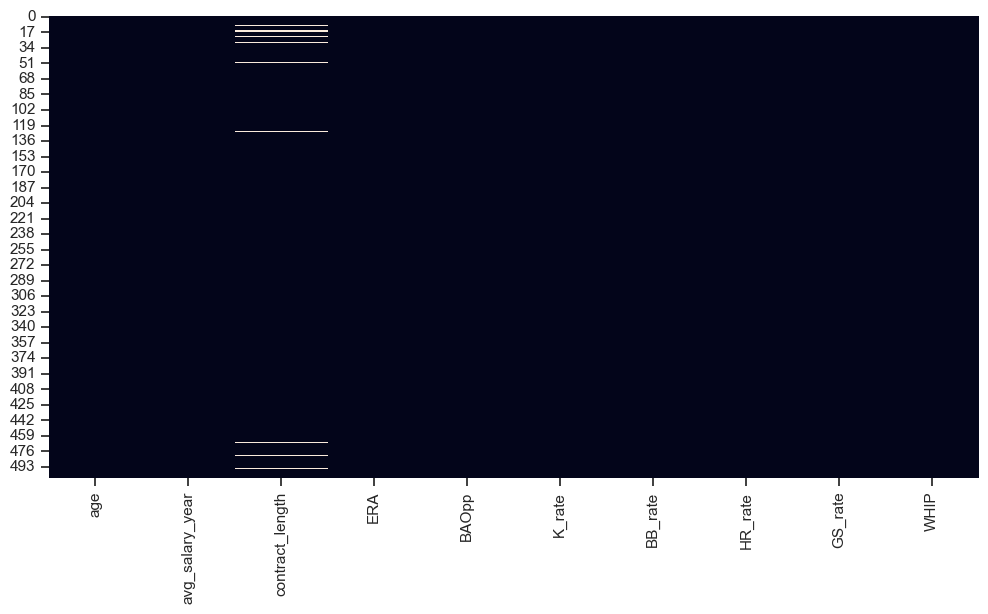

In [68]:
# Visualize missingness across engineered pitcher features
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(X.isnull(), cbar=False)
plt.show()

In [69]:
# Test whether contract_length missingness relates to key features
from scipy.stats import ttest_ind

# 1. Create the missingness indicator
X['contract_length_missing'] = X['contract_length'].isnull().astype(int)

features_to_test = ['age', 'avg_salary_year', 'ERA', 'BAOpp','K_rate', 'BB_rate', 'HR_rate', 'GS_rate', 'WHIP'] 

for feature in features_to_test:
    temp_df = X.copy()
    
    # Separate the feature values into two groups
    group_missing = temp_df.loc[temp_df['contract_length_missing'] == 1, feature]
    group_observed = temp_df.loc[temp_df['contract_length_missing'] == 0, feature]
    
    # t-test
    t_stat, p_value = ttest_ind(group_missing, group_observed, equal_var=False)

    print(f"\nFeature: **{feature}**")
    print(f"Mean (Missing contract_length): {group_missing.mean():.4f}")
    print(f"Mean (Observed contract_length): {group_observed.mean():.4f}")
    print(f"P-value: {p_value:.6f}")


Feature: **age**
Mean (Missing contract_length): 31.4545
Mean (Observed contract_length): 32.7616
P-value: 0.149254

Feature: **avg_salary_year**
Mean (Missing contract_length): 3042752.0799
Mean (Observed contract_length): 3247559.4995
P-value: 0.422667

Feature: **ERA**
Mean (Missing contract_length): 4.6006
Mean (Observed contract_length): 4.1406
P-value: 0.346261

Feature: **BAOpp**
Mean (Missing contract_length): 0.2752
Mean (Observed contract_length): 0.2575
P-value: 0.072287

Feature: **K_rate**
Mean (Missing contract_length): 0.1623
Mean (Observed contract_length): 0.1881
P-value: 0.062515

Feature: **BB_rate**
Mean (Missing contract_length): 0.0887
Mean (Observed contract_length): 0.0835
P-value: 0.584846

Feature: **HR_rate**
Mean (Missing contract_length): 0.0232
Mean (Observed contract_length): 0.0252
P-value: 0.513149

Feature: **GS_rate**
Mean (Missing contract_length): 0.0699
Mean (Observed contract_length): 0.4247
P-value: 0.000102

Feature: **WHIP**
Mean (Missing cont

There is no pattern to the missingness for most of the variables, but the test is significant for GS_rate, so most likely for relief pitchers their contract lengths are noticeably more missing compared to other variables. But we are using contract length for comparison not for cluster distinction so its ok to leave this as it is.

In [70]:
# Preserve original data and remove salary/contract columns before clustering
Xorig = X.copy()
X = X.drop(columns=['avg_salary_year', 'contract_length', 'contract_length_missing'])

In [71]:
# Use elbow method to explore candidate cluster counts
K_values = list(range(1, 11))
wcss = []

for k in K_values:
    pipe.set_params(kmeans__n_clusters=k)
    pipe.fit(X)
    inertia = pipe["kmeans"].inertia_
    wcss.append(inertia)


fig = px.line(
    x=K_values,
    y=wcss,
    markers=True,
    title="Elbow Plot (Pipeline: StandardScaler + KMeans)",
    labels={"x": "Number of Clusters (K)", "y": "WCSS / Inertia"}
)

fig.update_layout(height=500, width=700)
fig.show()

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Wi

k = 4 looks to be optimal based on elbow, look at sihouette score next

In [72]:
# Compute silhouette scores across cluster options
sil_scores = []
K_values_sil = list(range(2, 11))

for k in K_values_sil:
    pipe.set_params(kmeans__n_clusters=k)
    pipe.fit(X)

    labels = pipe["kmeans"].labels_

    sil = silhouette_score(X, labels)

    sil_scores.append(sil)


fig = px.line(
    x=K_values_sil,
    y=sil_scores,
    markers=True,
    title="Silhouette Scores (Pipeline: StandardScaler + KMeans)",
    labels={"x": "Number of Clusters (K)", "y": "Silhouette Score"}
)

fig.update_layout(height=500, width=700)
fig.show()


c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Wi

Looks like 2 clusters is best

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



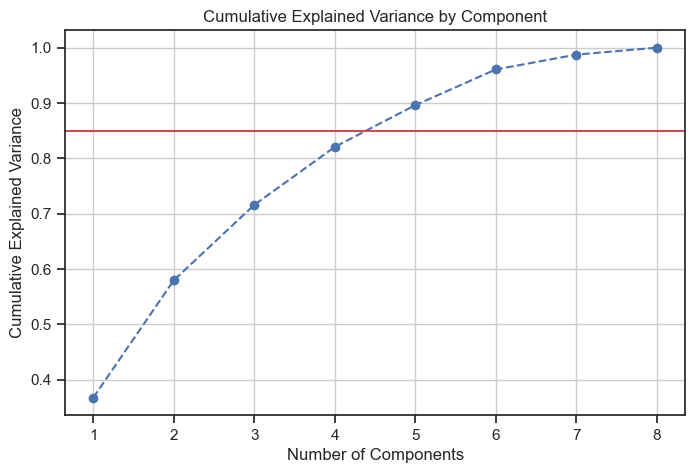

In [73]:
# Fit PCA to inspect explained variance prior to clustering
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=6021)),
    ("kmeans", KMeans(n_clusters=2, init="k-means++", n_init="auto", random_state=6021))
])

pipe.fit(X)
pca = pipe["pca"]

# cumulative explained variance plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, 9), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Component')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.85, color='r', linestyle='-') # Threshold line at 90%
plt.grid()
plt.show()

In [74]:
# Tabulate PCA eigenvalues and variance proportions
eigenvalues = pipe["pca"].explained_variance_
variance_ratios = pipe["pca"].explained_variance_ratio_
cumulative_variance = variance_ratios.cumsum()

import pandas as pd

pd.DataFrame({
    'Eigenvalue': eigenvalues,
    'Variance Proportion': variance_ratios,
    'Cumulative Variance': cumulative_variance
}, index=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'])

,Eigenvalue,Variance Proportion,Cumulative Variance
PC1,2.945404,0.367448,0.367448
PC2,1.700146,0.212098,0.579546
PC3,1.093320,0.136395,0.715941
PC4,0.839195,0.104692,0.820633
PC5,0.605138,0.075493,0.896126
PC6,0.517284,0.064533,0.960659
PC7,0.214869,0.026806,0.987464
PC8,0.100485,0.012536,1.000000


Setting a threshold of explaining at least 85% of the variance in the data, we successfully reduce our data from its 8 original dimensions to 5 principal components explaining 90% of the variance.

### Principal Direction Contributions

In [75]:
# Fit PCA with five components and inspect loadings
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=5, random_state=6021)),
    ("kmeans", KMeans(n_clusters=2, init="k-means++", n_init="auto", random_state=6021))
])

# 2. Fit PCA with 5 components
pipe.fit(X)
pca = pipe["pca"]

pca_loadings = pd.DataFrame(
    pipe["pca"].components_.T, 
    index=X.columns,
    columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
)
pca_loadings

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



,PC1,PC2,PC3,PC4,PC5
age,-0.170431,-0.292596,-0.496726,0.720712,0.210481
ERA,0.494226,0.107171,0.118993,0.129283,-0.255125
BAOpp,0.505120,-0.085956,-0.263190,-0.081112,-0.284329
K_rate,-0.379095,0.327673,0.315758,0.049323,-0.138427
BB_rate,0.083267,0.665271,0.033295,0.177144,0.539771
HR_rate,0.193486,-0.175389,0.676036,0.583417,-0.112435
GS_rate,0.195798,-0.486289,0.291425,-0.273830,0.668258
WHIP,0.495103,0.279856,-0.164529,0.090059,0.200102


We can see the decomposition of the 5 PCs here. For example PC1 is mostly contributed to by ERA, BAOpp, K_rate and WHIP. Meaning a higher or lower value in PC1 can be attributed or correlated to a higher or lower statistic for these 4 metrics.

### Principal Component Scores

In [76]:
# Transform dataset into PCA space for clustering
X_pca = pipe[:-1].transform(X) # Exclude the KMeans step to get PCA-transformed data
X_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=X.index)
X_pca

,PC1,PC2,PC3,PC4,PC5
0,2.697323,0.646495,0.287740,1.505867,1.266859
1,0.624663,2.124171,2.096422,1.899229,-0.178128
2,9.032733,1.647595,1.027779,2.078545,-2.632971
3,-0.392485,-0.203544,0.120252,-0.049660,0.150983
4,-0.266669,-0.198071,-0.572210,-0.910936,0.694120
...,...,...,...,...,...
501,-0.907309,-1.165954,0.904691,1.120804,0.945764
502,-0.424371,-1.066730,1.213456,-0.896062,0.121229
503,-1.057255,-1.766955,0.850717,-1.748368,-0.297524
504,-2.466369,-1.547228,0.620538,-1.380414,0.366807


Here we see the data being converted into our new input space, we have the reduction to 5 dimensions being displayed here, each observation in our data is now represented by the 5 PCs.

### PC Contribution to Variance Explanation

In [77]:
# Recompute eigenvalues and variance for the five-component PCA model
eigenvalues = pipe["pca"].explained_variance_
variance_ratios = pipe["pca"].explained_variance_ratio_
cumulative_variance = variance_ratios.cumsum()

import pandas as pd

pd.DataFrame({
    'Eigenvalue': eigenvalues,
    'Variance Proportion': variance_ratios,
    'Cumulative Variance': cumulative_variance
}, index=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])


,Eigenvalue,Variance Proportion,Cumulative Variance
PC1,2.945404,0.367448,0.367448
PC2,1.700146,0.212098,0.579546
PC3,1.093320,0.136395,0.715941
PC4,0.839195,0.104692,0.820633
PC5,0.605138,0.075493,0.896126


c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



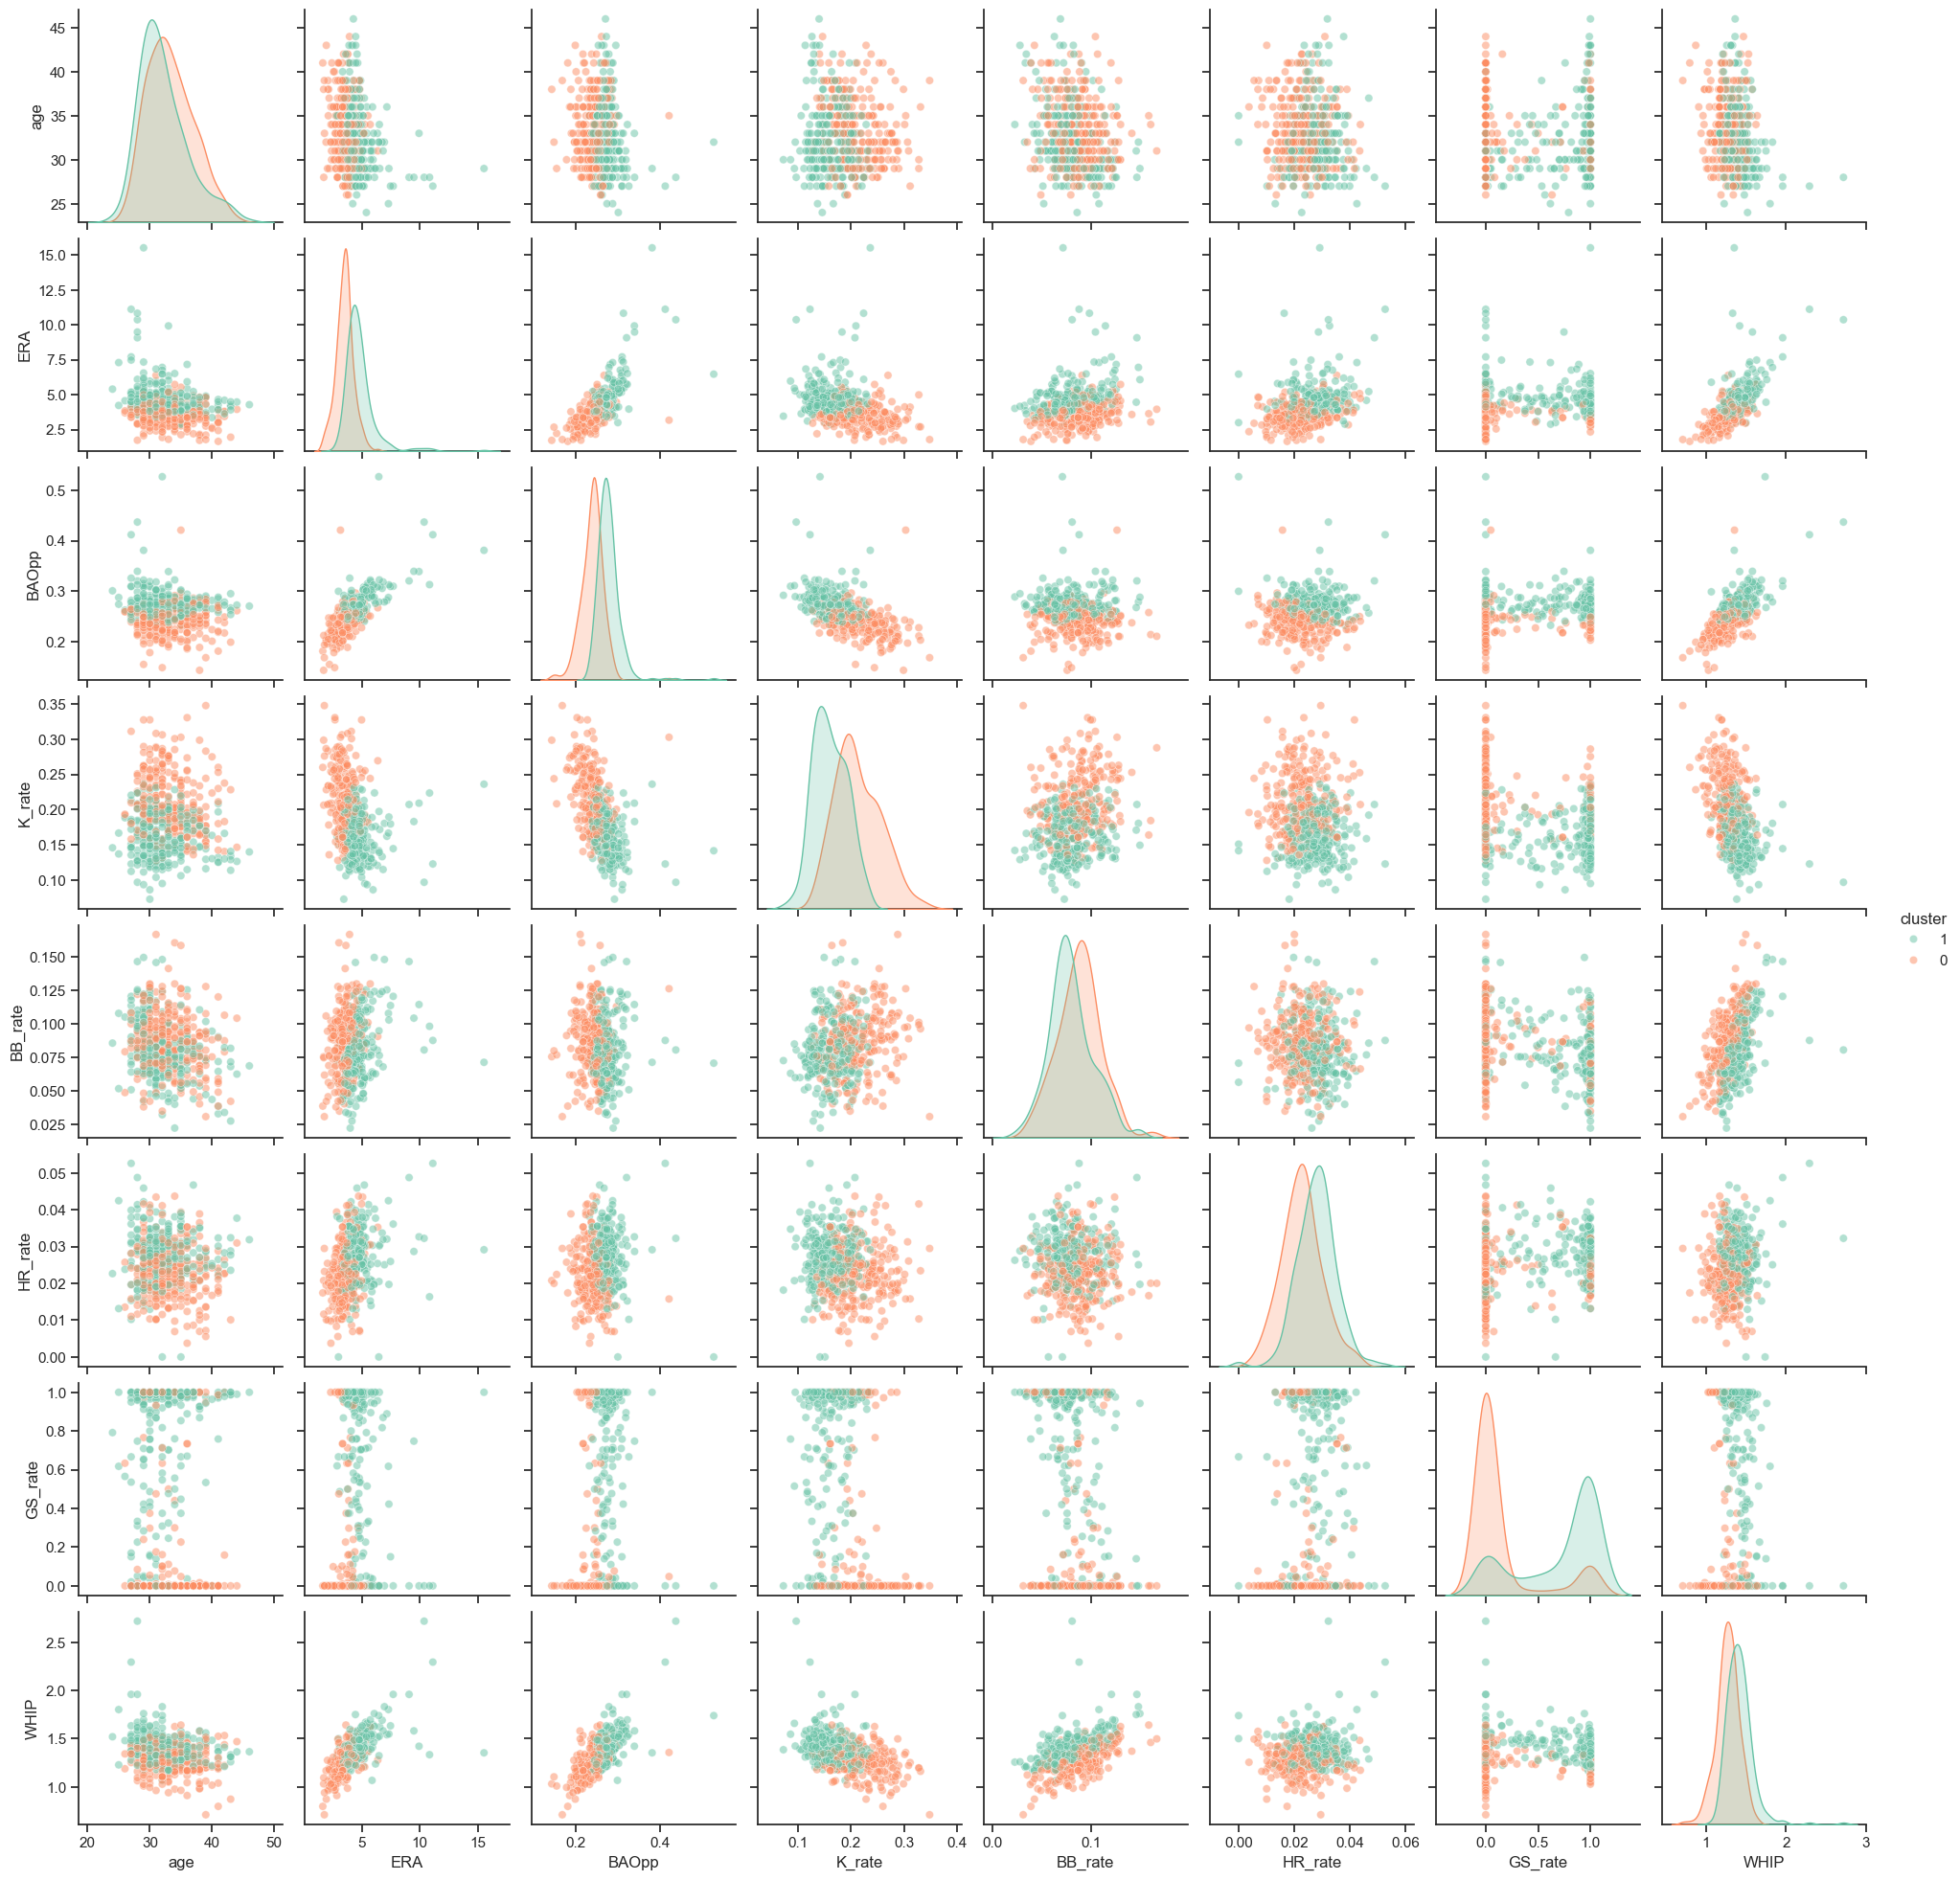

In [78]:
# Cluster on engineered features and visualize pairwise distributions
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd

# original data kmeans clustering analysis

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=5, random_state=6021)),
    ("kmeans", KMeans(n_clusters=2, init="k-means++", n_init="auto", random_state=6021))
])

pipe.fit(X)
labels = pipe["kmeans"].labels_

X_plot = pd.DataFrame(X, columns=['age', 'ERA', 'BAOpp', 'K_rate', 'BB_rate', 'HR_rate', 'GS_rate', 'WHIP'])
X_plot['cluster'] = labels.astype(str)

# pairwise plot of PC Scores
sns.set(style="ticks")
pair_plot = sns.pairplot(
    X_plot, 
    hue='cluster', 
    palette='Set2', 
    diag_kind='kde',
    plot_kws={'alpha': 0.5})

plt.show()

GS_rate does the best at separating clusters, but since it is the main loading factor only in PC5, it means it doesn't explain a lot of variance. But we can expect to see the clusters somehow relate to relief vs starter pitchers. K_rate also seems to do well at separation, and it is a big contributor to PC1, 2, and 3 so it also explains a lot of variance.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



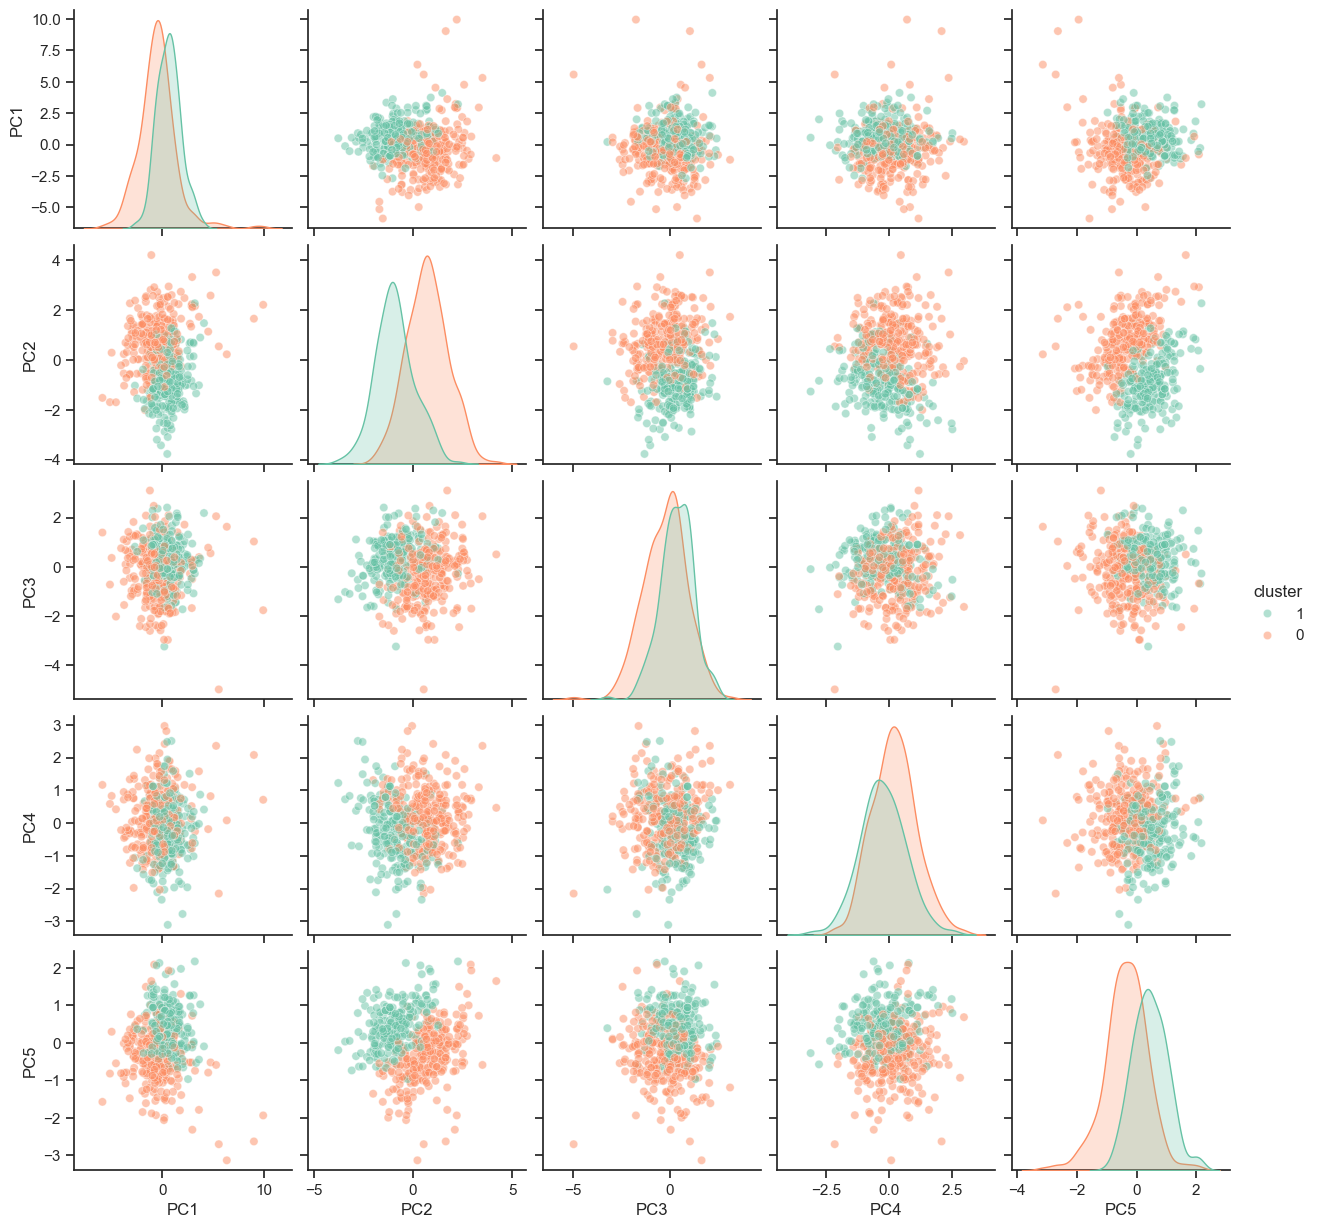

In [79]:
# Cluster on PCA-transformed features and create biplots
# pca transformed data kmeans clustering analysis

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=5, random_state=6021)),
    ("kmeans", KMeans(n_clusters=2, init="k-means++", n_init="auto", random_state=6021))
])

pipe.fit(X_pca)
labels = pipe["kmeans"].labels_

X_plot = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
X_plot['cluster'] = labels.astype(str)
cluster_labels = X_plot['cluster'].unique()

def plot_pca_biplot(X_pca_scores, loadings_matrix, labels, pc_x=1, pc_y=2, scale_factor=8, cluster_distinction=True):
    """
    Generates a PCA Biplot for any two Principal Components (PCX vs PCY), 
    colored by K-means cluster labels.

    Args:
        X_pca_scores (pd.DataFrame or np.array): The PCA transformed data (PC scores).
        loadings_matrix (pd.DataFrame): The matrix of PCA loadings.
        labels (np.array): The K-means cluster labels for each data point.
        pc_x (int): The index of the PC for the X-axis (e.g., 1 for PC1).
        pc_y (int): The index of the PC for the Y-axis (e.g., 2 for PC2).
        scale_factor (float): Multiplier to scale the loading vectors for visualization.
    """
    
    pc_x_col = f'PC{pc_x}'
    pc_y_col = f'PC{pc_y}'
    
    if pc_x_col not in X_plot.columns or pc_y_col not in X_plot.columns:
        raise ValueError(f"PC index {pc_x} or {pc_y} is out of range. Max PC is {len(X_plot.columns)-1}.")
        
    cluster_labels = X_plot['cluster'].unique()

    fig = go.Figure()

    # Scatter Plot of Data Points (Scores)
    if cluster_distinction:
        for label in cluster_labels:
            df_cluster = X_plot[X_plot['cluster'] == label]
            fig.add_trace(go.Scatter(
                x=df_cluster[pc_x_col], 
                y=df_cluster[pc_y_col], 
                mode='markers',
                marker=dict(size=8, opacity=0.7),
                name=f'Cluster {label}'
            ))
    else:
        fig.add_trace(go.Scatter(
            x=X_plot[pc_x_col], 
            y=X_plot[pc_y_col], 
            mode='markers',
            marker=dict(size=8, opacity=0.7),
        ))

    # 3. Add Loadings (Arrows)
    # The loadings matrix contains the coordinates for the arrows
    loading_df = loadings_matrix[[pc_x_col, pc_y_col]].copy()
    loading_df['var'] = loading_df.index

    for i, row in loading_df.iterrows():
        fig.add_trace(go.Scatter(
            x=[0, row[pc_x_col] * scale_factor], 
            y=[0, row[pc_y_col] * scale_factor],
            mode='lines+markers+text',
            text=[None, row["var"]],
            textposition='top center',
            line=dict(color='red', width=2),
            marker=dict(size=5, color='red'),
            showlegend=False,
            textfont=dict(color='red', size=12)
        ))

    # 4. Final Layout
    fig.update_layout(
        title=f'PCA Biplot: {pc_x_col} vs {pc_y_col}',
        xaxis_title=pc_x_col,
        yaxis_title=pc_y_col,
        height=600,
        width=800,
        # Ensure the arrow origin (0,0) is visible
        xaxis=dict(zeroline=True, zerolinewidth=2, zerolinecolor='lightgrey'),
        yaxis=dict(zeroline=True, zerolinewidth=2, zerolinecolor='lightgrey'),
    )
    fig.show()

plot_pca_biplot(X_pca, pca_loadings, labels, pc_x=1, pc_y=2)

plot_pca_biplot(X_pca, pca_loadings, labels, pc_x=1, pc_y=3)

plot_pca_biplot(X_pca, pca_loadings, labels, pc_x=1, pc_y=5)

# pairwise plot of PC Scores
sns.set(style="ticks")
pair_plot = sns.pairplot(
X_plot, 
hue='cluster', 
palette='Set2', 
diag_kind='kde',
plot_kws={'alpha': 0.5})

plt.show()


All 5 PCs contribute to separating the clusters, we see PC5 as expected does well compared to the others despite not explaining alot of variance in the data, and we see PC1 does less at separation but explains a lot of variance.

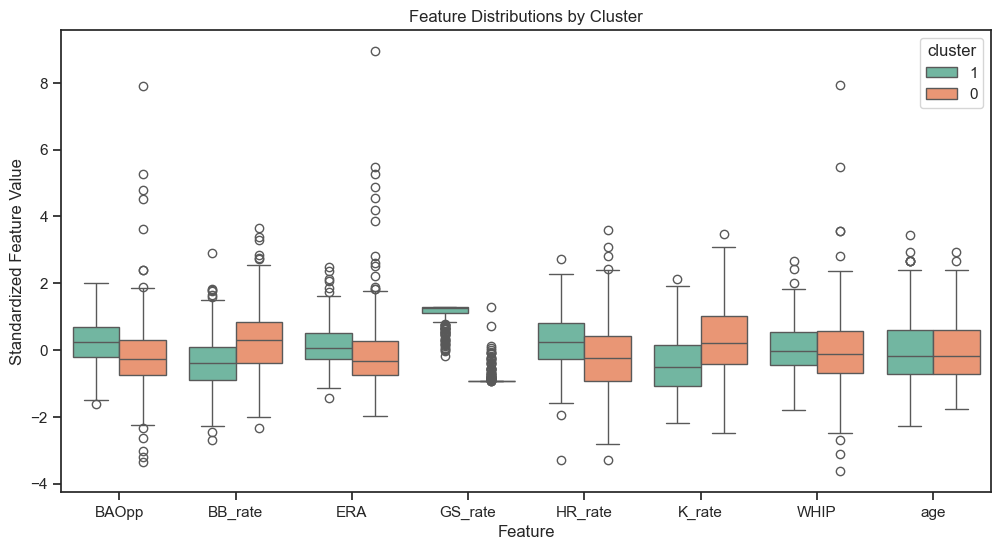

In [80]:
# Compare standardized feature distributions across clusters
X['cluster'] = labels.astype(str)
# standardize to account for range differences
X_scaled = X.copy()
X_scaled['cluster'] = labels.astype(str)
feature_cols = X.columns.difference(['cluster'])
X_scaled[feature_cols] = StandardScaler().fit_transform(X[feature_cols])
plot_df = X_scaled.melt(id_vars='cluster', value_vars=X_scaled.columns.difference(['cluster']), var_name='Feature', value_name='Value')
plt.figure(figsize=(12,6))
sns.boxplot(x='Feature', y='Value', hue='cluster', data=plot_df, palette='Set2')
plt.title("Feature Distributions by Cluster")
plt.ylabel("Standardized Feature Value")
plt.xlabel("Feature")
plt.show()

As expected, the biggest distinguishing factor does appear to GS_Rate, hence our PC5 scatterplot and kde. K_rate, BB_rate also do pretty well. We can say that for cluster 1, it is mostly made up of pitchers who are starter pitchers, they have lower strikeout rates from being in more innings and lower walk rates, aka they are good at avoiding giving up bases. The other cluster are relief pitchers who hit hard and want to get strikeouts for an inning or two.

### Salary and Contract Length Comparisons Across Clusters

In [81]:
# Summarize salary and contract length by cluster
Xorig['cluster'] = labels.astype(str)
Xorig.groupby('cluster')[['avg_salary_year', 'contract_length']].agg(['mean','median','std', 'count'])

avg_salary_year                                    contract_length  \
                   mean        median            std count            mean   
cluster                                                                      
0          3.214142e+06  3.277647e+06  563567.097269   285        1.505455   
1          3.280460e+06  3.278747e+06  567078.069045   221        1.763636   

                                
        median       std count  
cluster                         
0          1.0  0.807677   275  
1          1.0  1.309796   220

In [82]:
# Visualize salary and contract length distributions by cluster
fig_salary = px.box(
    Xorig, 
    x='cluster', 
    y='avg_salary_year', 
    color='cluster',
    title="Average Yearly Salary by Batter Cluster",
    labels={'avg_salary_year': 'Avg Salary per Year ($)', 'cluster': 'Batter Segment'},
)
fig_salary.show()

fig_len = px.box(
    Xorig, 
    x='cluster', 
    y='contract_length', 
    color='cluster',
    title="Contract Length by Batter Cluster",
    labels={'contract_length': 'Years of Contract', 'cluster': 'Batter Segment'},
)
fig_len.show()

No very evident differences between clusters for salary and contract.

### Is this significant difference?

In [83]:
# Perform t-tests on salary and contract length between clusters
from scipy import stats

cluster_0_salary = Xorig[Xorig['cluster'] == '0']['avg_salary_year']
cluster_1_salary = Xorig[Xorig['cluster'] == '1']['avg_salary_year']

t_stat, p_val = stats.ttest_ind(cluster_0_salary, cluster_1_salary, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4e}")

if p_val < 0.05:
    print("Result: Significant. The market values these player segments differently.")
else:
    print("Result: Not significant. The clusters do not represent a meaningful pay difference.")

cluster_0_contract = Xorig[Xorig['cluster'] == '0']['contract_length'].dropna()
cluster_1_contract = Xorig[Xorig['cluster'] == '1']['contract_length'].dropna()

t_stat, p_val = stats.ttest_ind(cluster_0_contract, cluster_1_contract, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4e}")

if p_val < 0.05:
    print("Result: Significant. The market contracts these player segments differently.")
else:
    print("Result: Not significant. The clusters do not represent a meaningful contract length difference.")

T-statistic: -1.3083
P-value: 1.9141e-01
Result: Not significant. The clusters do not represent a meaningful pay difference.
T-statistic: -2.5601
P-value: 1.0887e-02
Result: Significant. The market contracts these player segments differently.


In [84]:
# Compute Cohen's d effect sizes for salary and contract differences
import numpy as np

def cohens_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / dof)

d = cohens_d(cluster_0_contract, cluster_1_contract)
print(f"contract Cohen's d: {d:.4f}")
d = cohens_d(cluster_0_salary, cluster_1_salary)
print(f"salary Cohen's d: {d:.4f}")

contract Cohen's d: -0.2435
salary Cohen's d: -0.1174


The difference in terms of standard deviations is not that great despite the t test being significant, at best we have a modest difference in contract lengths between cluster 1 and 0, and the pay difference is negligible.